# Classification Metrics

Suppose we train a model on the MNIST dataset to classify handwritten numbers into numbers. We will classify if the number is a 5 or not a 5 for simplicity. In this notebook we will examine different methods of measuring the performance of a model. 

Let's start by importing the data and implementing a simple SGDClassifier because it is efficient for large datasets:

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [7]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import LogisticRegression

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, loss="log",random_state=42)
sgd_clf.fit(X_train, y_train_5)
y_pred_5 = sgd_clf.predict(X_test)

## Accuracy

The simplest way to measure performance is to see how often the classifier guesses the correct value. Let's see the result on our test set:

In [15]:
np.count_nonzero(y_test_5 == y_pred_5)/len(y_test_5)

0.9704

Wow! A 97% accuracy!

**BE WARY** Here we got a 97% accuracy but if we just randomly guessed we would get a 90% accuracy. So when dealing with *skewed datasets* where certain features are more common than others than be aware of this problem.

## Confusion Matrix

Instead of measuring the total accuracy we can measure how many times the predictor predicts each feature and how many of those are correct or incorrect. We can summarise it as follows using the class A:

*True Positives*  - how many of A were correctly classified as A 

*False Positives* - how many of not A were wrongly correctly classified as A

*True Negatives* - how many of not A  were correctly classified as not A

*False Negatives* - how many of not A were wrongly correctly classified as not A

We can do this for every class in a dataset and compare each feature to every other feature. In total this produces a confusion matrix as seen below:

In [45]:
test_vec = (y_test_5 == 1)

true_positives  = 0
false_positives = 0
true_negatives  = 0
false_negatives = 0
for i in range(len(y_test_5)):
    if (y_pred_5[i] == 1) and (y_test_5[i] == 1):
        true_positives +=1
    if (y_pred_5[i] == 1) and (y_test_5[i] == 0):
        false_positives +=1
    if (y_pred_5[i] == 0) and (y_test_5[i] == 1):
        false_negatives +=1
    if (y_pred_5[i] == 0) and (y_test_5[i] == 0):
        true_negatives +=1
        
np.array([[true_negatives, false_positives],[false_negatives, true_positives]])

array([[9022,   86],
       [ 210,  682]])

## Precision and Recall

Precision is defined as how accurate the true positives are relation to all the positves. The formula for this is:

$$\text{precision}=\frac{TP}{TP+FP}$$

Recall is defined as the amount of amount of true positives in relation to all instances belonging to a class. The formula for this is:

$$\text{recall}=\frac{TP}{TP+FN}$$

With more precision we can more precisly say whether our positves are correct, but at the cost of recall since less instances will be classified as positives. This is called the *Precision/Recall Trade-Off* and can be measured in different ways the most common being their harmonic mean which is called the $F_1$ score. An $F_1$ score close to 1 is the best:

$$F_1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}$$

Now lets implement this:

In [46]:
precision = true_positives/(true_positives+false_positives)
recall    = true_positives/(true_positives+false_negatives)
f1_score  = 2/(1/precision + 1/recall)

print("precision: " + str(precision))
print("recall: " + str(recall))
print("f1_score: " + str(f1_score))

precision: 0.8880208333333334
recall: 0.7645739910313901
f1_score: 0.821686746987952


We can see that we have a high precision but a lower recall. This can be adjusted by varying different probabilities or by looking at the ROC curve:

## ROC Curve

The *reciever operating characteristic* (ROC) curve is a that plots *sensitivity* vs *specificity*. We can define them as follows:

**Sensitivity:** The sensitivity is the *true positive rate* (recall)

**Specificity:** The specificity is the *false positive rate* (1-sensitivity)

In generic terms we can say that sensitivity is what proportion of the actual positives that were correctly classified and specificity is the proportion of actual negatives that were incorrectly classified. The ROC is a curve that plots these two against eachother for different thresholds:

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_5, y_pred_5)

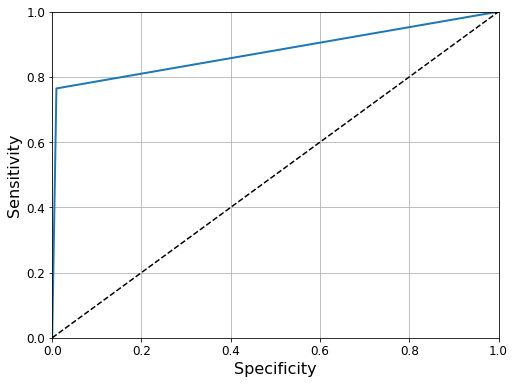

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('Specificity', fontsize=16) 
    plt.ylabel('Sensitivity', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)                       
plt.show()

The graph above looks OK but we see the curve doesn't perfectly match the top of the square. To quantify this we can measure the area under the curve for the ROC which is called the ROC AUC score. Here it is implemented with sklearn:

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_5, y_pred_5)

0.8775658712293534